In [1]:
# Data Processing
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns   # plotting heatmap
import matplotlib.pyplot as plt
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC

from scipy.stats import randint, uniform
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [2]:
def metrics_function(confusion_matrix):
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TN = confusion_matrix[1][1]
    TPR = TP / (TP + FN) # Recall
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    NPV = TN / (TN + FN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    ACCURACY = (TP + TN) / (TP + FP + FN + TN)
    PRECISION = TP / (TP + FP)
    ERROR_RATE = (FP + FN) / (TP + FP + FN + TN)
    F1 = (2 * TP) / (2 * TP + FP + FN)
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    return [TP, TN, FP, FN, TPR, TNR, FPR, FNR, PRECISION, F1, ACCURACY, ERROR_RATE, BACC, TSS, HSS]


In [3]:
# Get data features and labels
# Split the data into features (X) and target (y)

sentiment_data = pd.read_csv(f'{os.getcwd()}/dataset/review_sentiment_labelled.csv')
X = sentiment_data["Sentence"]
y = sentiment_data['Score']
train_sentiment, test_sentiment, train_score, test_score = train_test_split(X, y, test_size=0.3)

vectorizer = CountVectorizer()

vector_sentiment_train = vectorizer.fit_transform(train_sentiment)
vector_sentiment_test = vectorizer.transform(test_sentiment)


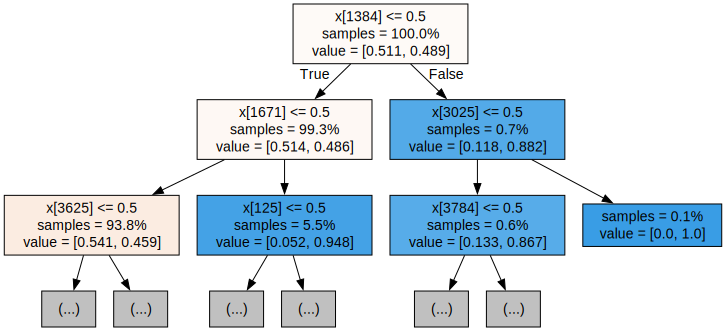

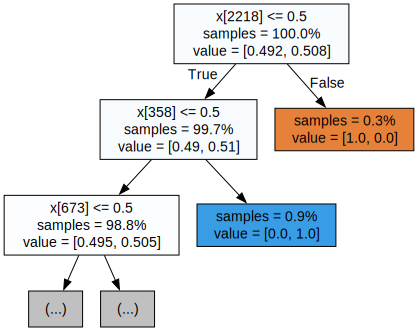

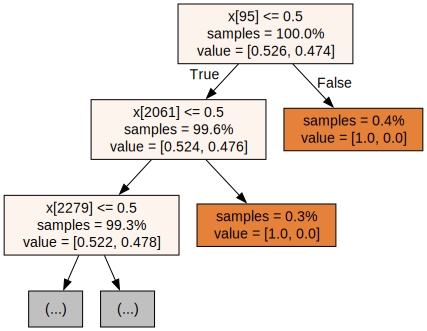

Best hyperparameters: {'max_depth': 12, 'n_estimators': 457}


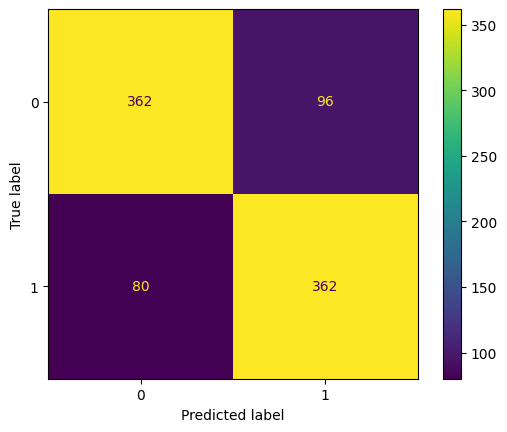

In [4]:
# Random Forrest Implementation
rf = RandomForestClassifier()
rf.fit(vector_sentiment_train, train_score)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=10)

# Fit the random search object to the data
rand_search.fit(vector_sentiment_train, train_score)
# # Create a variable for the best model
best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

#Confusion Matrix setup, prediction with the best models
predicted_score_best = best_rf.predict(vector_sentiment_test)
cm = confusion_matrix(test_score, predicted_score_best)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [ ]:
# Support Vector Machine Implementation
svm = SVC()
param_dist = {
    'C': uniform(0.1, 10),  # Uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 50))
}
randomized_search = RandomizedSearchCV(estimator=svm, param_distributions=param_dist, n_iter=10, cv=10)

randomized_search.fit(vector_sentiment_train, train_score)

print("Best Hyperparameters: ", randomized_search.best_params_)
best_svm = randomized_search.best_estimator_

predicted_score_best_svm = best_svm.predict(vector_sentiment_test)
cm_svm = confusion_matrix(test_score, predicted_score_best_svm)

ConfusionMatrixDisplay(confusion_matrix=cm_svm).plot();

# # Scatter plot
# plt.scatter(X[:, 0], X[:, 1], 
#             c=y, 
#             s=20, edgecolors="k")
# plt.show()



In [6]:
rf_evaluate = []
svm_evaluate = []
metric_des = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision','F1_measure', 'Accuracy', 'Error_rate', 'BACC', 
              'TSS', 'HSS']
# Implement KFold cross validation (To be continued) Also remember to add the Brier score, ROC, 
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)
iter = 0
for tr_index, ts_index in k_fold.split(X):
    iter += 1
    print(f'Iteration {iter}')
    print(best_rf.max_depth)
    rf_model_iter = RandomForestClassifier(max_depth=best_rf.max_depth, n_estimators=best_rf.n_estimators) # Initialize RF with best params
    svm_model_iter = SVC(C=best_svm.C, gamma=best_svm.gamma, kernel=best_svm.kernel) # Initialize SVM with best params
    train_sentiment, test_sentiment = X[tr_index], X[ts_index]
    train_score, test_score = y[tr_index], y[ts_index]
    vectorizer_inx = CountVectorizer()
    vector_sentiment_train_inx = vectorizer_inx.fit_transform(train_sentiment)
    vector_sentiment_test_inx = vectorizer_inx.transform(test_sentiment)
     # Fit models with training data and label for each iteration
    rf_model_iter.fit(vector_sentiment_train_inx, train_score)
    svm_model_iter.fit(vector_sentiment_train_inx, train_score) 
    # Get the Predicted value for the models for each iteration
    predicted_rf_inx = rf_model_iter.predict(vector_sentiment_test_inx)
    predicted_svm_inx = svm_model_iter.predict(vector_sentiment_test_inx)
    # Get the confusion matrix for the models for each iteration
    cm_rf_inx = confusion_matrix(test_score, predicted_rf_inx)
    cm_svm_inx = confusion_matrix(test_score, predicted_svm_inx)
    rf_metric_inx = metrics_function(cm_rf_inx)
    svm_metric_inx = metrics_function(cm_svm_inx)
    rf_evaluate.append(rf_metric_inx)
    svm_evaluate.append(svm_metric_inx)
    evaluated_metrics = pd.DataFrame([rf_metric_inx, svm_metric_inx], columns=metric_des, index=['RF', 'SVM'])
    print(evaluated_metrics.round(2).T)
    
    

<generator object _BaseKFold.split at 0x775f86f607b0>
Iteration 1
13
                RF     SVM
TP          121.00  113.00
TN          113.00  137.00
FP           51.00   27.00
FN           15.00   23.00
TPR           0.89    0.83
TNR           0.69    0.84
FPR           0.31    0.16
FNR           0.11    0.17
Precision     0.70    0.81
F1_measure    0.79    0.82
Accuracy      0.78    0.83
Error_rate    0.22    0.17
BACC          0.79    0.83
TSS           0.58    0.67
HSS           0.57    0.66
Iteration 2
13
                RF     SVM
TP          133.00  137.00
TN          111.00  120.00
FP           26.00   17.00
FN           30.00   26.00
TPR           0.82    0.84
TNR           0.81    0.88
FPR           0.19    0.12
FNR           0.18    0.16
Precision     0.84    0.89
F1_measure    0.83    0.86
Accuracy      0.81    0.86
Error_rate    0.19    0.14
BACC          0.81    0.86
TSS           0.63    0.72
HSS           0.62    0.71
Iteration 3
13
                RF     SVM
TP        